<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Banglore</h1>

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [66]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [67]:
df1.shape
#(rows,col)

(13320, 9)

In [68]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [69]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [70]:
df1['area_type'].value_counts()
# Count of rows based on the vrious area types

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

**Drop features that are not required to build our model**

In [71]:
# Assuming these features not hugely afftect estate prices , we are dropping it
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape
# col reduced to 5 from 9

(13320, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

First is the data cleaning process on which data scientist spend most of the time

In [72]:
df2.isnull().sum()
# gives count of na values in each column

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [73]:
df2.shape

(13320, 5)

In [74]:
# Dropping all 'na' containing rows
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [75]:
df3.shape
#hence the no of rows reduced

(13246, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [76]:
# creating a new column 'bhk' by splitting via space the string in 'size' column eg. '4 bhk' or '4 bedroom' & taking 
# only index 0 ie. '4' the numerical part . Hence now by 'int(...)' we convert it to integer
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\rishu\AppData\Local\Temp\ipykernel_20916\3947212101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [77]:
df3.total_sqft.unique()
# here we find that the area in sq feet has some range values like '1133 - 1384'.

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [78]:
# To separate all range values we pass it to is_float fxn where range values cant be floated will returned as False
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [79]:
# by '~' we take false values here when df3['total_sqft'] area in sq feet is passed to the fxn
df3[~df3['total_sqft'].apply(is_float)].head(10) #here we are seeing 1st 10 such values

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [80]:
# this fxn takes range values and make array of LHL & RHL (2 values) by splitting via '-'

def convert_sqft_to_num(x):
    tokens = x.split('-')
    # Hence range values are converted to their avg by below
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
   # and single values like '1056' remains same by below
    try:
        return float(x)
    except:
        return None   #returns nothing for values like 4125Perch (hence drops those rows)

In [81]:
df4 = df3.copy() # creates a deep copy of df3[df3 is till now cleaned dataframe object]
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [82]:
df4.loc[549]

location      Hennur Road
size                2 BHK
total_sqft         1317.5
bath                  2.0
price               63.77
bhk                     2
Name: 549, dtype: object

In [83]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [84]:
df5 = df4.copy()
# price/totalsqfeet * 1lac gives price in lacs per sq feet of plot
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [85]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [86]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [87]:
df5.location = df5.location.apply(lambda x: x.strip()) #like trim fxn in java to remove trailing spaces if any
location_stats = df5['location'].value_counts(ascending=False) #sort the locations in descending order of their frequency
location_stats #here location_stats is a series of pandas library ie. 1D array

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [88]:
location_stats.values.sum() # total no of locations or rather rows (basically adding 533, 392, 304 etc.)

13200

In [89]:
len(location_stats[location_stats>10]) # total no of locations having frequency below 10

240

In [90]:
len(location_stats) # total number of unique locations

1287

In [91]:
len(location_stats[location_stats<=10]) # total number of unique locations with frequency <10

1047

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [92]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [93]:
len(df5.location.unique())

1287

In [94]:
# hence this line put all locations with freq<10 as 'other' string hence Rajanna Layout, Subramanyanagar etc. will occur as
# 'other' now with freq= 1047 (see In 27)
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [95]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [96]:
# showing all rows where per BHK area is less than 300sqft
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [97]:
df5.shape

(13200, 7)

In [98]:
# the rows which have per BHK area >=300 are df6:-
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [99]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

Using mean and standard deviation is a statistical method to identify outliers. It assumes that most data points 
(around 68% in a normal distribution) lie within one standard deviation from the mean. As 'price_per_sqft' is a normally
distributed data hence we can consider only the rows that lie in 68% range of values of 'price_per_sqft' depending on 'location'

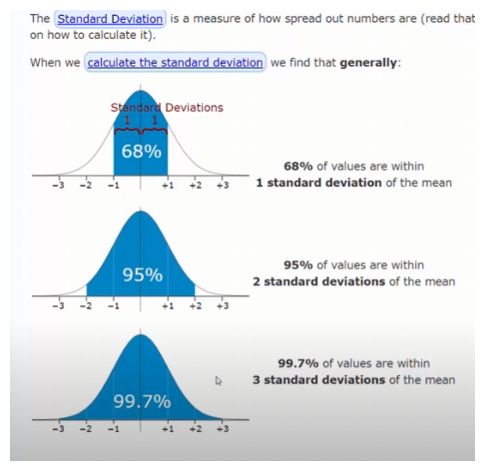

In [100]:
img = plt.imread('p1.PNG')
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [101]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
# here we group by location to find mean and std dev wrt each location and then concatenate it to df_out each time
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    # ignore_index dont consider index of each each group while concatenating hence indexing is continuous as '0'to total
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape
# hence almost 2000 outliers removed from (12456, 7)

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

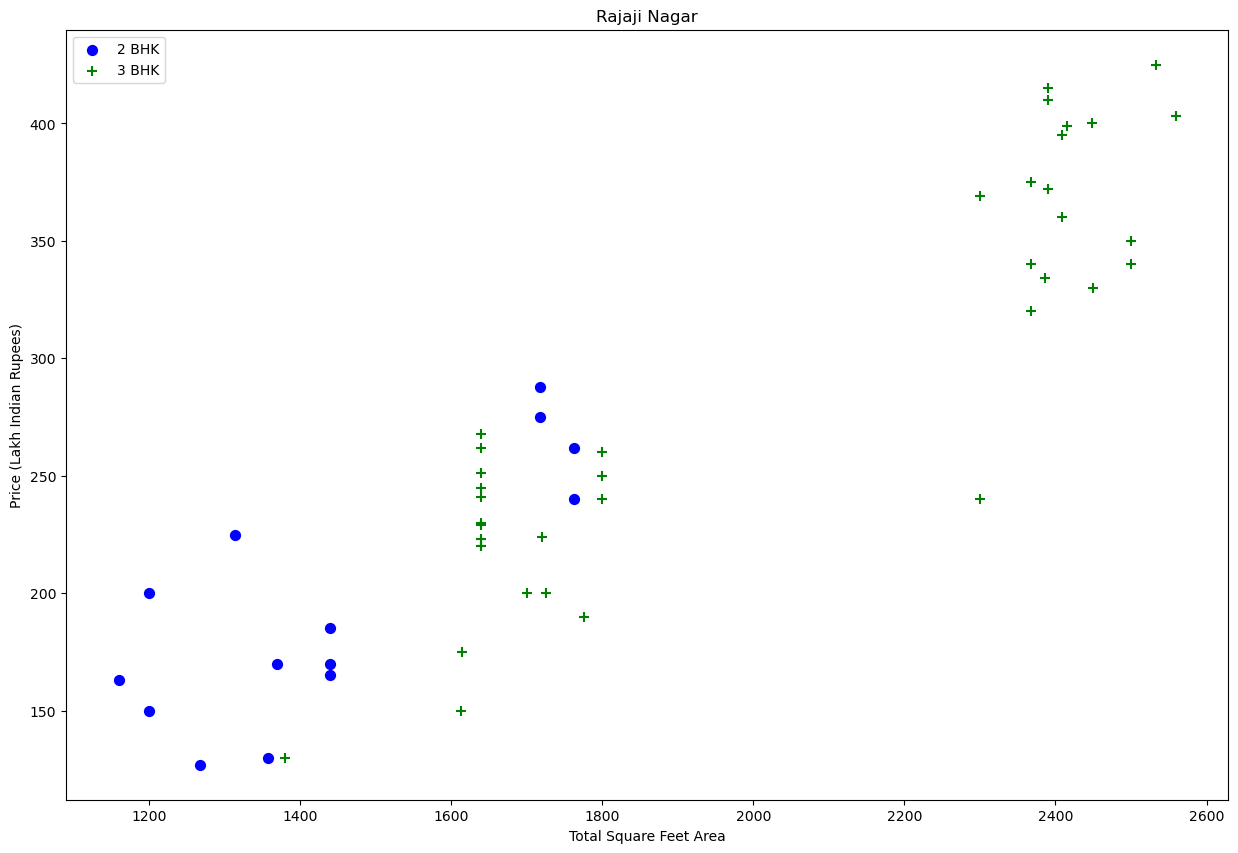

In [102]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)] # bhk2 be 'Rajaji Nagar''s 2bhk plots
    bhk3 = df[(df.location==location) & (df.bhk==3)] # bhk3 be 'Rajaji Nagar''s 3bhk plots
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar") # to show by some location here we consider 'Rajaji Nagar'

# we find that 2BHK blue dots are higher than 3BHK '+' at same sq feet area and location Rajaji Nagar, hence 
# removing such outliers

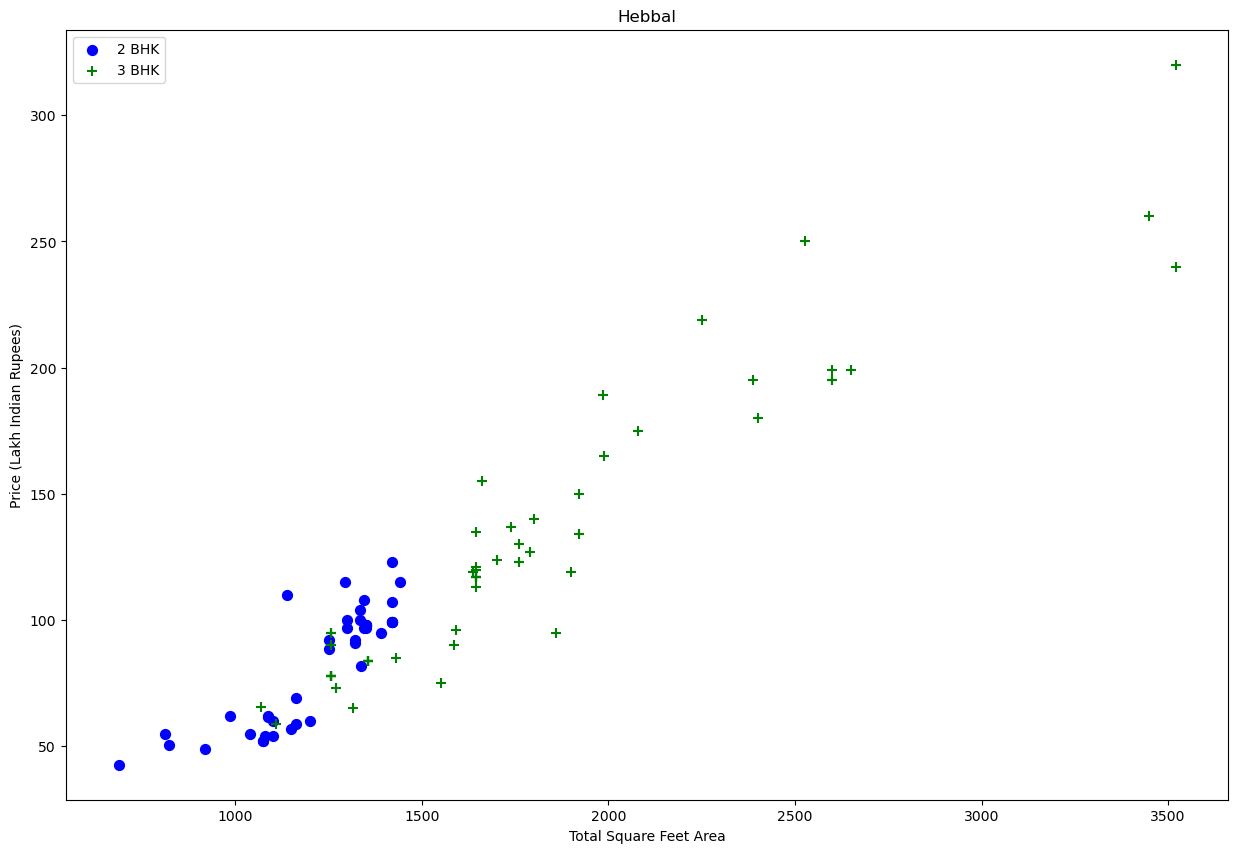

In [103]:
plot_scatter_chart(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [104]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    # first grouping based on location
    for location, location_df in df.groupby('location'):
        # In that grouped location , creating a dictionary for each BHK
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        # In that grouped location for each BHK :
        for bhk, bhk_df in location_df.groupby('bhk'):
            # if the 1 less bhk than current bhk has count ie. no of rows more than 5 hence significant values then we chk:
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                # We  chk that if high-bhk rows have price less than mean price of low-bhk rows then we drop those rows
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape
# hence almost 3000 outliers removed from (10242, 7)

(7317, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

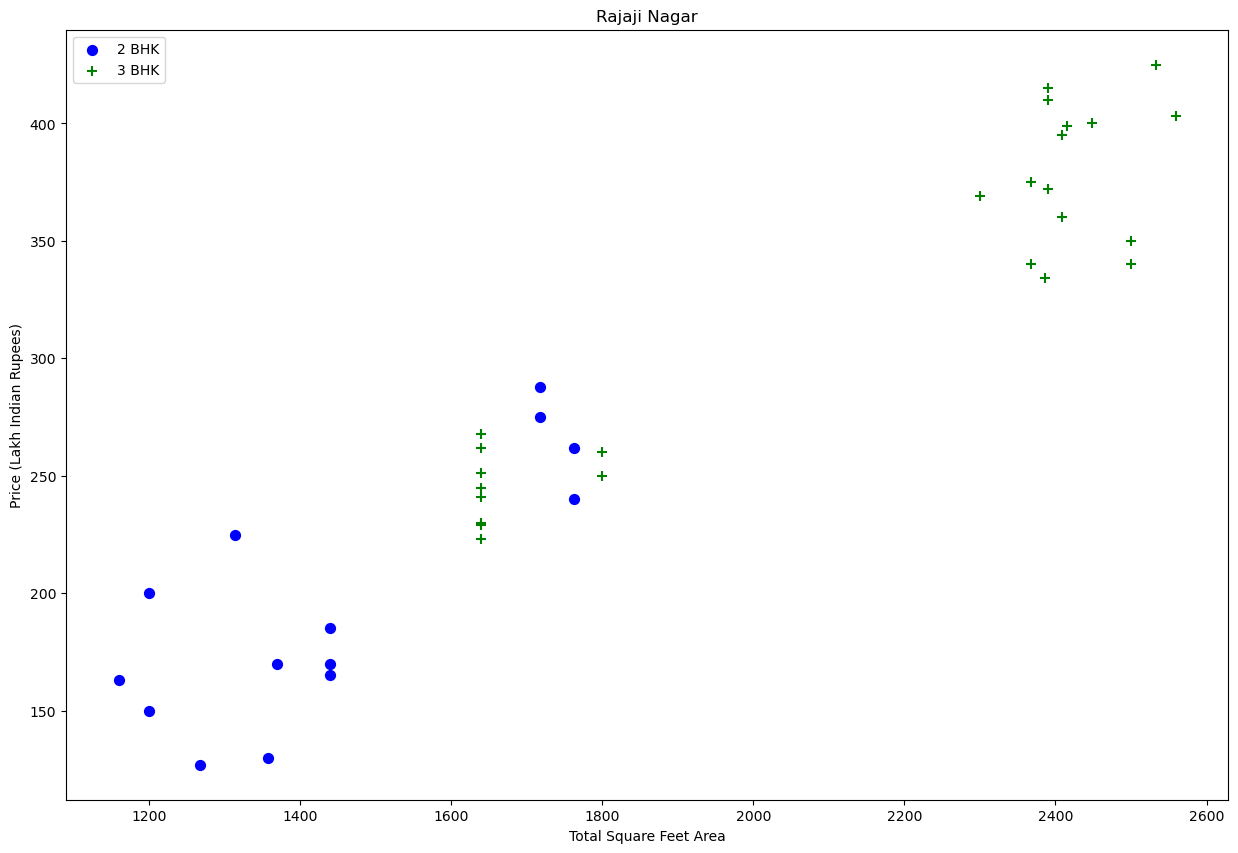

In [105]:
plot_scatter_chart(df8,"Rajaji Nagar")

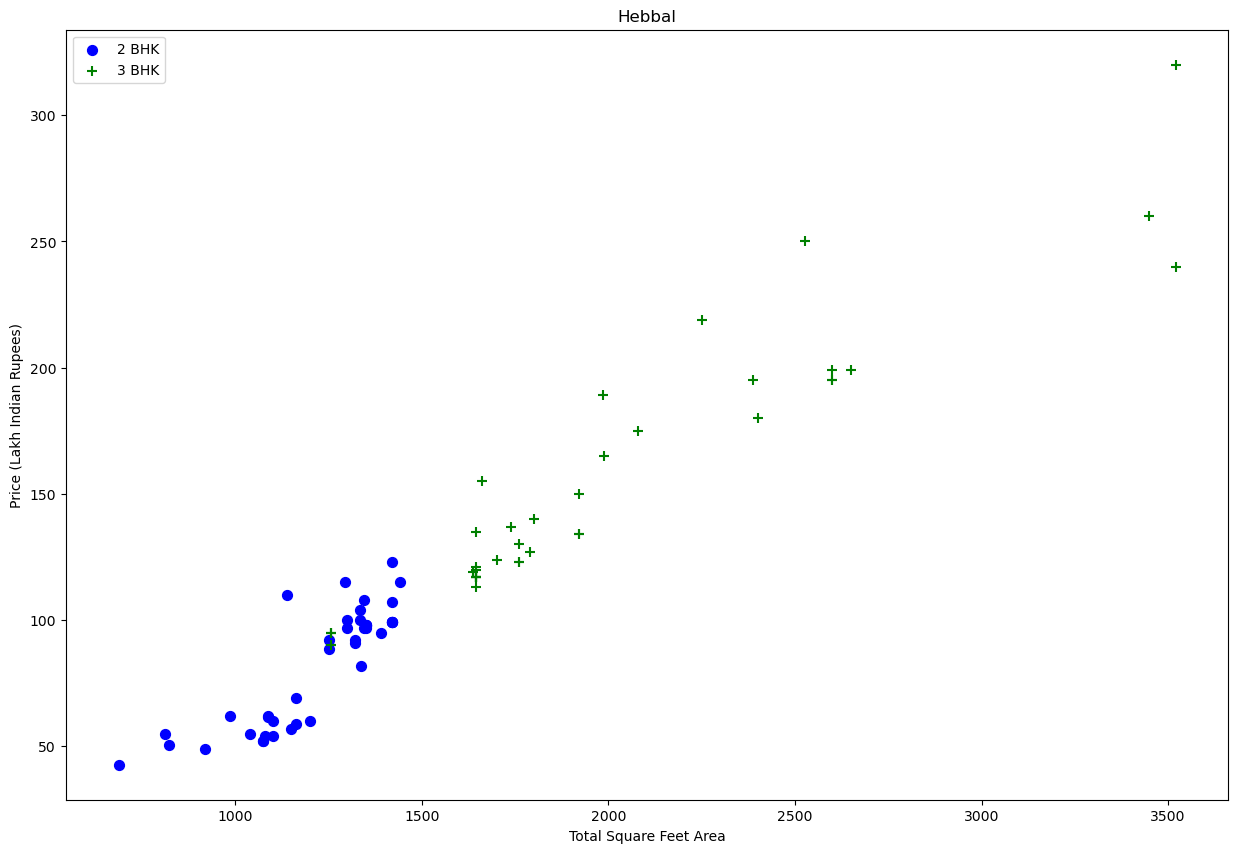

In [106]:
plot_scatter_chart(df8,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

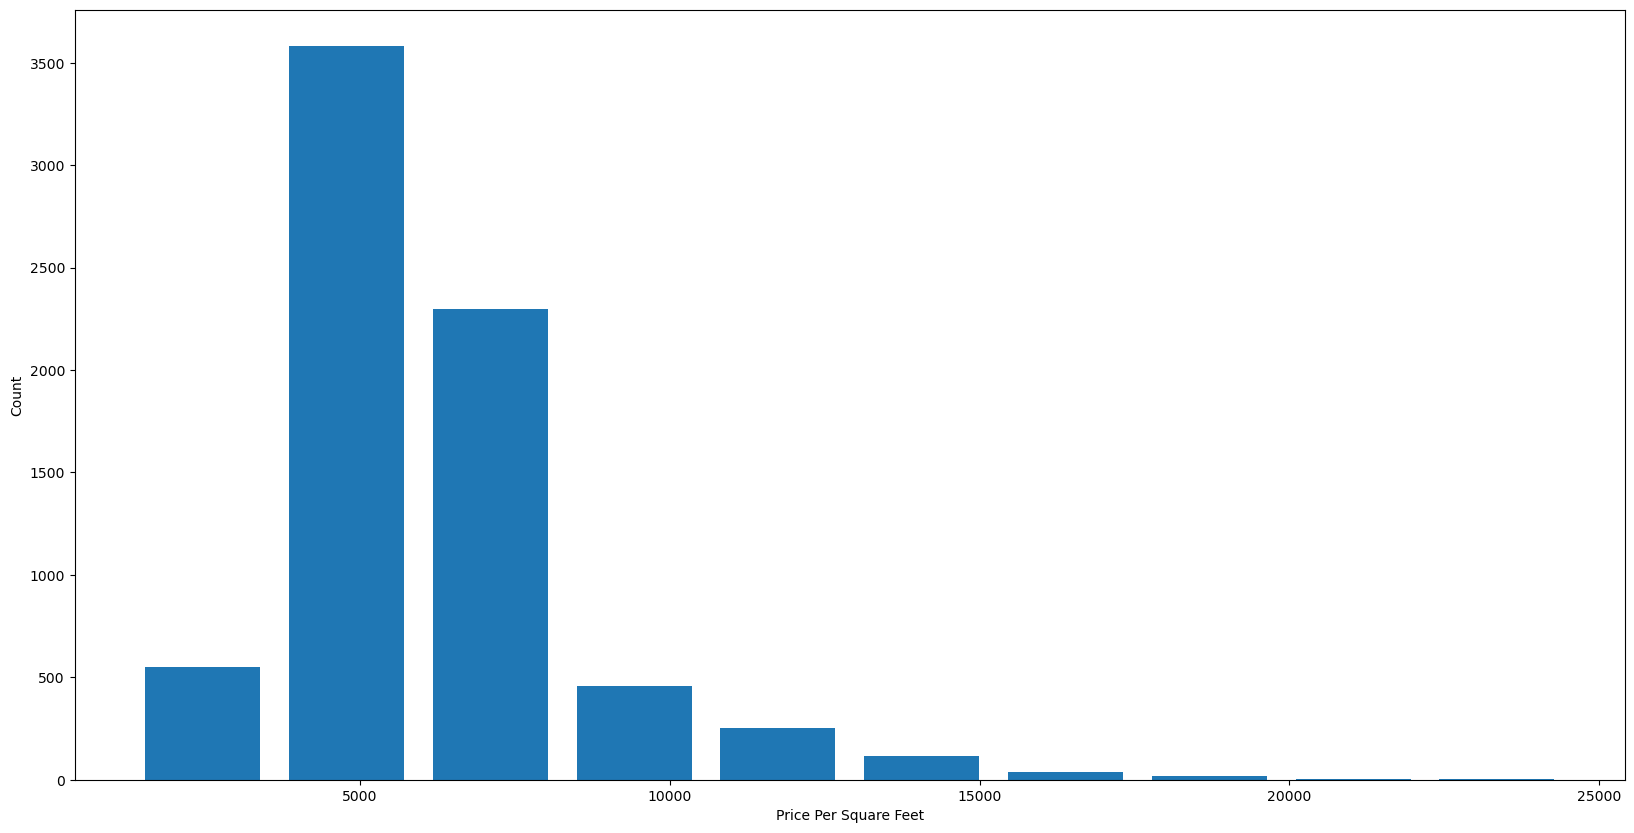

In [116]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
# shows normal distribution where majority of plots are of 5000 sq ft 

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [117]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

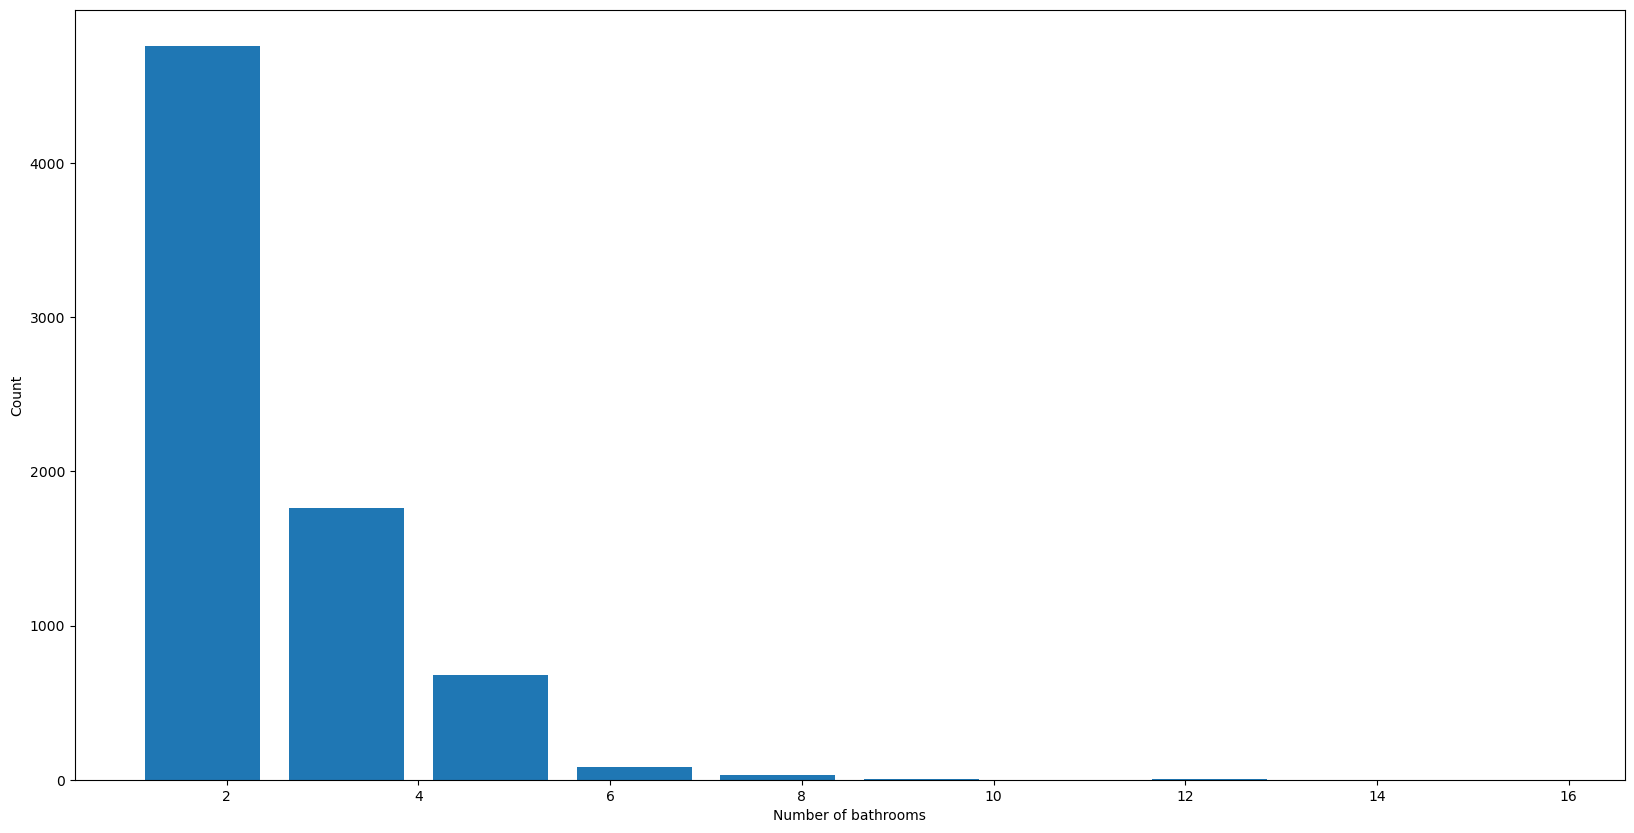

In [118]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
# most property has 2 baths

In [119]:
df8[df8.bath>10]
# shows all properties with more than 10 baths

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual if no of bathrooms are greater than (1+number of bhk) in a home**

**Hence the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [120]:
# hence taking only rows with bathrooms < = (1+ its no of BHK)
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [121]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [122]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns') 
# as bhk is same as size and price_per_sqft was only for outlier detection hence dropping them
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [123]:
# One hot encoding : ie. converting text(location) data into binary values to diferentiate them for training our model 
# based on location
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
# to avoid dummy variable trap we drop one column say 'other' as we can just represent it via all 0s rather than creating a 1 for it 
# as a separate column
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style='color:blue'>Build a Model Now...</h2>

We are ready to train our model as data cleaning is done 

In [126]:
df12.shape

(7239, 244)

In [127]:
X = df12.drop(['price'],axis='columns') # input for training as X-axis
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
X.shape

(7239, 243)

In [129]:
y = df12.price # prediction y-axis
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [130]:
len(y)

7239

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10) 
# keeping 80% data for training and 'random_state=10' splits same values for test and train everytime to maintain consistency 
# across different experiments.  

In [132]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

# our accuracy is 86% via linear Regression model

0.8629132245229447

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [133]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# generate 5 different training and test sets (hence 5 fold), where each test set will contain 20% of the data, and 
# the remaining 80% will be used for training. this happens the same way if executed again due to 'random_state'

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [134]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # again taking 5 fold for each combination criteria
    for algo_name, config in algos.items():
    # via for loop it provides the dict's model and parameters array for permuation combination to find model scores
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

D:\Applications\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
D:\Applications\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': False}
1,lasso,0.726772,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.718051,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [142]:
np.where(X.columns) # gives array of column indices 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [146]:
np.where(X.columns=='1st Phase JP Nagar') #  gives 2D array of only 1 element ie. index of '1st Phase JP Nagar'

(array([4], dtype=int64),)

In [149]:
np.where(X.columns=='1st Phase JP Nagar')[0][0] # gives  index of '1st Phase JP Nagar'

4

In [155]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns)) # creates a Numpy array x filled with zeros, with length same as number of columns in array
    x[0] = sqft # as 0 , 1 , 2 are column index of sqft, bath and bhk rspt
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1  # as per one hot encoding the column needed has binary 1 hence making its index value as 1

    return lr_clf.predict([x])[0] 
# .predict can take 2d array or dataframe input...here [x] is a 2d array
# lr_clf.predict([x]) returns a 1d array with 1 element as predicted value
# hence we take only its value by 'lr_clf.predict([x])[0]'

In [156]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

D:\Applications\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.86570258311586

In [157]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

D:\Applications\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.08062284986354

In [158]:
predict_price('Indira Nagar',1000, 2, 2)

D:\Applications\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


193.3119773317968

In [159]:
predict_price('Indira Nagar',1000, 3, 3)

D:\Applications\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


195.52689759854445

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [160]:
import pickle  # saves our trained model
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [164]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns] # converting all columns into lowercase and 
    # creating a dictionary for (json file)
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

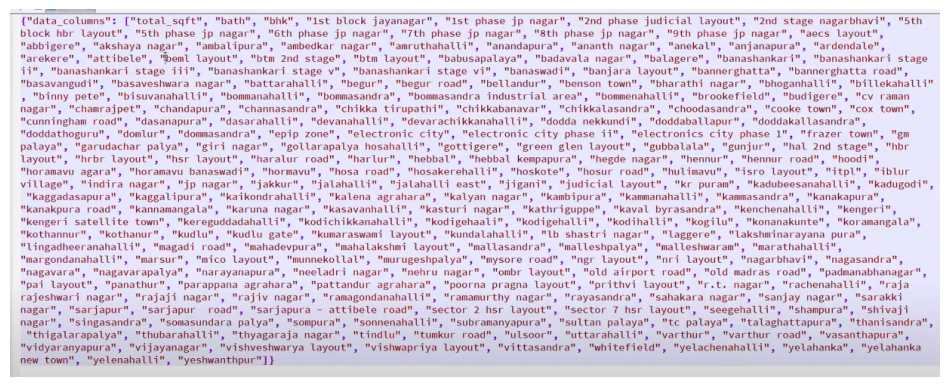

In [163]:
img = plt.imread('p2.PNG')
plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.axis('off')
plt.show()